<a name="tableofcontents"></a>

# Battle of the Neighborhoods Part 2: Best Resterurants in New York City

### Applied Data Science Capstone

<a name="introduction"></a>

## 1. Background & Problem Description

New York City is one of the most diverse and populated cities in the world. It is a melting pot of different cultures and cuisines from around the world. It is also considering a foodie heaven because there are so many options. That means that there are a lot of options to choose from and that selecting the best place can be tough. It should be important to know which places are the best depending upon the neighborhood you are in. This project will help to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Place API’ and ‘k-means’ clustering machine learning algorithm. The audience would be anyone that is interested to use this analysis to understand the distribution of different cultures and cuisines in New York City. 

<a name="data"></a>[Scroll Back to Table of Contents](#tableofcontents)

## 2. Data

To examine the above said, following data sources will be used:

1.  **New York City Dataset**
    *  Link: <https://geo.nyu.edu/catalog/nyu_2451_34572>
    *  The data set will be our base neighborhood data set to cross reference against the Foursquare API venue data

2.  **Foursquare API:**
    *  Link: <https://developer.foursquare.com/docs>
    *  Description: Foursquare API, a location data provider, will be used to make RESTful API calls to retrieve data about venues in different neighborhoods. This is the link to [Foursquare Venue Category Hierarchy](https://developer.foursquare.com/docs/resources/categories). Venues retrieved from all the neighborhoods are categorized broadly into "Arts & Entertainment", "College & University", "Event", "Food", "Nightlife Spot", "Outdoors & Recreation", etc. An extract of an API call is as follows:

2.  **Geophy Library in Python:**
    * Description: This will help us get the Lat and Long of the NYC data set

<a name="methodology">[Scroll Back to Table of Contents](#tableofcontents)

## 2. Methodology

Download all the dependencies.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Download and Explore New York City Dataset

In order to segment the neighborhoods of New York City, a dataset is required that contains the 5 boroughs and the neighborhoods, that exist in each borough, with respective latitude and longitude coordinates. We will download the data set and upload in our working directory

* To the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572, and
* To its downloadable json format file: https://cocl.us/new_york_dataset/newyork_data.json

In [3]:
#Move file into local directory and create variable
Data = 'nyu_2451_34572-geojson.json'

In [4]:
# open & load downloaded file, print its type
with open(Data) as json_data:
    newyork_data = json.load(json_data)
type(newyork_data)

dict

In [5]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [6]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


#### Tranform the data into a *pandas* dataframe

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.

In [11]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

#### Define Foursquare Credentials and Version
Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [13]:
CLIENT_ID = 'QXGYVTSQLO0EHISX3GIOTZVSATCJWT2L2CKXOJYZKOPHKVJB' # your Foursquare ID
CLIENT_SECRET = 'IC344XWNJT5KAEYONE5U4DU1IFRIJMWHP2E3U2VB1NOX4ANA' # your Foursquare Secret
VERSION = '20200225' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QXGYVTSQLO0EHISX3GIOTZVSATCJWT2L2CKXOJYZKOPHKVJB
CLIENT_SECRET:IC344XWNJT5KAEYONE5U4DU1IFRIJMWHP2E3U2VB1NOX4ANA


**Fetch Foursquare Venue Category Hierarchy**

In [14]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

Let's see the structure or the keys of the returned request.

In [15]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [16]:
category_list = category_results['response']['categories']

In [17]:
len(category_list)

10

In [18]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**_Food_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Food_ & It's Sub-Categories.

In [19]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [20]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in _Food_ with their id's.

#### Explore the first neighborhood to understand the results of GET Request

Get the neighborhood's name.

In [21]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

Get the neighborhood's latitude and longitude values.

In [22]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


#### Now, let's get the _Food_ that is in Wakefield within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [23]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=QXGYVTSQLO0EHISX3GIOTZVSATCJWT2L2CKXOJYZKOPHKVJB&client_secret=IC344XWNJT5KAEYONE5U4DU1IFRIJMWHP2E3U2VB1NOX4ANA&v=20200225&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

Send the GET request and examine the resutls

In [24]:
results = requests.get(url).json()

In [25]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1582659590',
  'hasPerk': False}]

The category name of the venue **'Carvel Ice Cream'** is **'Food'**.

As, our aim is to segment the neighborhoods of NYC with respect to the _Food_ in its vicinity. We need to proceed further to fetch this data from all the 306 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the neighborhoods in NYC:
* Loop through neighborhoods
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each neighborhood, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [26]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [27]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [28]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


<a name="analysis"> [Scroll Back to Table of Contents](#tableofcontents)

## 3. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [29]:
print(nyc_venues.shape)
nyc_venues.head()

(13908, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
1,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,SUBWAY,40.890468,-73.849152,Sandwich Place
4,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant


#### Let's find out how many unique categories can be curated from all the returned venues

In [30]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 202 uniques categories.


Venue Category
Deli / Bodega                               1047
Pizza Place                                 1037
Coffee Shop                                  906
Donut Shop                                   637
Fast Food Restaurant                         619
Chinese Restaurant                           604
Bakery                                       547
Italian Restaurant                           542
American Restaurant                          442
Café                                         426
Caribbean Restaurant                         361
Mexican Restaurant                           339
Bagel Shop                                   335
Sandwich Place                               324
Fried Chicken Joint                          323
Diner                                        287
Restaurant                                   253
Ice Cream Shop                               225
Food                                         205
Burger Joint                                 185
Japan

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [31]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Ice Cream Shop, Donut Shop, Caribbean Restaurant, Sandwich Place, Fast Food Restaurant, Deli / Bodega, Bakery, Food, Comfort Food Restaurant, Fried Chicken Joint, Latin American Restaurant, Pizza Place, Spanish Restaurant, Chinese Restaurant, Food Truck, Southern / Soul Food Restaurant, Coffee Shop, American Restaurant, Halal Restaurant, Seafood Restaurant, Burger Joint, Bagel Shop, Mexican Restaurant, Dumpling Restaurant, Steakhouse, BBQ Joint, Italian Restaurant, African Restaurant, Restaurant, Diner, Grocery Store, Juice Bar, Café, Asian Restaurant, Breakfast Spot, Wings Joint, Sushi Restaurant, Bar, Frozen Yogurt Shop, Japanese Restaurant, Tapas Restaurant, Indian Restaurant, Empanada Restaurant, Vegetarian / Vegan Restaurant, Greek Restaurant, Korean Restaurant, Cuban Restaurant, Pub, Falafel Restaurant, Gas Station, Cafeteria, Other Nightlife, Soup Place, Hot Dog Joint, Arcade, New American Restaurant, Dessert Shop, Health Food Store, French Restaurant, Convenience Store, Buffet,

In [33]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [34]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Varenyky restaurant, Indonesian Restaurant, Kosher Restaurant, Tex-Mex Restaurant, Dosa Place, Churrascaria, Sushi Restaurant, Hong Kong Restaurant, Taco Place, Empanada Restaurant, Russian Restaurant, Shanghai Restaurant, Colombian Restaurant, Cajun / Creole Restaurant, Japanese Restaurant, Szechuan Restaurant, Bath House, Fried Chicken Joint, African Restaurant, Israeli Restaurant, Asian Restaurant, Arepa Restaurant, Pakistani Restaurant, Portuguese Restaurant, Thai Restaurant, Burrito Place, Polish Restaurant, Halal Restaurant, Dutch Restaurant, Taiwanese Restaurant, Persian Restaurant, Dim Sum Restaurant, American Restaurant, Food Service, Caribbean Restaurant, BBQ Joint, Shabu-Shabu Restaurant, Caucasian Restaurant, Peruvian Restaurant, Pop-Up Shop, Australian Restaurant, Chocolate Shop, Filipino Restaurant, South American Restaurant, Sri Lankan Restaurant, Egyptian Restaurant, Greek Restaurant, Speakeasy, Korean Restaurant, Spanish Restaurant, Vietnamese Restaurant, Eastern Europ

Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.

In [35]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,2,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant
1,4,Wakefield,40.894705,-73.847201,Burger King,40.895540,-73.856460,Fast Food Restaurant
2,6,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
3,10,Wakefield,40.894705,-73.847201,Popeyes Louisiana Kitchen,40.889322,-73.843323,Fried Chicken Joint
4,11,Wakefield,40.894705,-73.847201,McDonald's,40.892779,-73.857473,Fast Food Restaurant


In [36]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 104 unique FOOD categories.


#### Let's find out how many unique venues can be curated from all the returned venues

In [37]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3381 uniques venues.


### Analyze Each Neighborhood

In [38]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bath House,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Hong Kong Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pop-Up Shop,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Sake Bar,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bath House,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Hong Kong Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pop-Up Shop,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Sake Bar,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [40]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bath House,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Hong Kong Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pop-Up Shop,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Sake Bar,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [41]:
nyc_onehot.shape

(6944, 105)

Let's count venues of each category in each neighborhood

In [42]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bath House,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Hong Kong Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pop-Up Shop,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Sake Bar,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's find out the top 10 food categories in NYC

In [43]:
venue_counts_described = venue_counts.describe().transpose()

In [44]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.374172,1.875457,0.0,0.0,0.0,0.0,28.0
Caribbean Restaurant,302.0,1.195364,2.772356,0.0,0.0,0.0,1.0,17.0
Indian Restaurant,302.0,0.337748,1.027123,0.0,0.0,0.0,0.0,13.0
Chinese Restaurant,302.0,2.000000,1.971559,0.0,1.0,2.0,3.0,13.0
Italian Restaurant,302.0,1.794702,2.004374,0.0,0.0,1.0,3.0,12.0
Fast Food Restaurant,302.0,2.049669,1.939496,0.0,1.0,1.5,3.0,12.0
Pizza Place,302.0,3.433775,2.122632,0.0,2.0,3.0,5.0,10.0
Seafood Restaurant,302.0,0.500000,0.830282,0.0,0.0,0.0,1.0,8.0
Filipino Restaurant,302.0,0.092715,0.493829,0.0,0.0,0.0,0.0,7.0
Fried Chicken Joint,302.0,1.069536,1.326374,0.0,0.0,1.0,2.0,7.0


In [45]:
venue_top10_list = venue_top10.index.values.tolist()

#### Visualize the Data Distribution

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 2000x2000 with 10 Axes>

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [47]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bath House,Brazilian Restaurant,Burrito Place,Cajun / Creole Restaurant,Cambodian Restaurant,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Chocolate Shop,Churrascaria,Colombian Restaurant,Cuban Restaurant,Czech Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Hobby Shop,Hong Kong Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pop-Up Shop,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Sake Bar,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Yemeni Restaurant
0,Allerton,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.055556,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.166667,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.105263,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.111111,0.0,0.0,0.055556,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.055556,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.222222,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0000,0.0

#### Let's confirm the new size

In [48]:
nyc_grouped.shape

(302, 105)

#### Let's write a function to sort the venues in descending order.

In [49]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [50]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [51]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [52]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,Annadale,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,American Restaurant,Peruvian Restaurant,Fast Food Restaurant,Spanish Restaurant
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Mediterranean Restaurant,Polish Restaurant


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [53]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [54]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

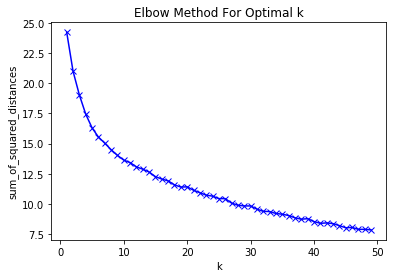

In [55]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [56]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

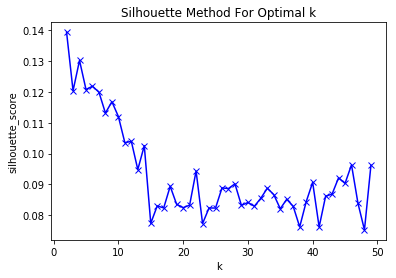

In [57]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

There is a peak at k = 2, k = 4 and k = 8. Two and four clusters will give a very broad classification of the venues.
#### Let's set number of clusters = 8

In [58]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({0: 57, 2: 47, 7: 47, 5: 42, 3: 41, 4: 40, 1: 25, 6: 3})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [59]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [60]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant
1,5,Annadale,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Japanese Restaurant
2,5,Arden Heights,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Mexican Restaurant
3,5,Arlington,Pizza Place,American Restaurant,Peruvian Restaurant,Fast Food Restaurant,Spanish Restaurant
4,4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Mediterranean Restaurant,Polish Restaurant


In [61]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,2,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
1,5,Annadale,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,5,Arden Heights,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,5,Arlington,Pizza Place,American Restaurant,Peruvian Restaurant,Fast Food Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
4,4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Mediterranean Restaurant,Polish Restaurant,Staten Island,40.596313,-74.067124


Finally, let's visualize the resulting clusters

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='results'></a>[Scroll Back to Table of Contents](#tableofcontents)

## 5. Results

In [63]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

#### Cluster 0

In [64]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
6,Astoria,Fast Food Restaurant,Mediterranean Restaurant,Chinese Restaurant,Vietnamese Restaurant,American Restaurant,Queens,40.768509,-73.915654
8,Auburndale,Korean Restaurant,Greek Restaurant,Sushi Restaurant,American Restaurant,Cantonese Restaurant,Queens,40.761730,-73.791762
9,Bath Beach,Fast Food Restaurant,Chinese Restaurant,Cantonese Restaurant,Sushi Restaurant,Vietnamese Restaurant,Brooklyn,40.599519,-73.998752
11,Bay Ridge,Fast Food Restaurant,Thai Restaurant,American Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Brooklyn,40.625801,-74.030621
14,Bayside,Korean Restaurant,Chinese Restaurant,Fast Food Restaurant,Asian Restaurant,Sushi Restaurant,Queens,40.766041,-73.774274


In [65]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                    16
Fast Food Restaurant            8
Italian Restaurant              6
Mexican Restaurant              5
Korean Restaurant               5
Sushi Restaurant                3
Thai Restaurant                 2
Indian Restaurant               2
Seafood Restaurant              2
Greek Restaurant                1
Russian Restaurant              1
Ramen Restaurant                1
Sri Lankan Restaurant           1
Asian Restaurant                1
Eastern European Restaurant     1
Chinese Restaurant              1
American Restaurant             1
Filipino Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                        9
Italian Restaurant                 8
Fast Food Restaurant               8
Mexican Restaurant                 6
Chinese Restaurant                 6
Latin American Restaurant          2
Thai Restaurant                    2
Vietnamese Restaurant              2
Russ

#### Cluster 1

In [66]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
37,Brownsville,Caribbean Restaurant,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Fast Food Restaurant,Brooklyn,40.663950,-73.910235
41,Cambria Heights,Caribbean Restaurant,Fried Chicken Joint,Mexican Restaurant,African Restaurant,Latin American Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Chinese Restaurant,Caribbean Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Brooklyn,40.635564,-73.902093
77,East Flatbush,Caribbean Restaurant,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Fast Food Restaurant,Brooklyn,40.641718,-73.936103


In [67]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    21
Chinese Restaurant       2
American Restaurant      1
Fried Chicken Joint      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fast Food Restaurant    7
Fried Chicken Joint     5
Pizza Place             5
Chinese Restaurant      4
Caribbean Restaurant    3
Seafood Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         11
Queens            8
Bronx             5
Staten Island     1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 2

In [68]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Chinese Restaurant,Mexican Restaurant,Fried Chicken Joint,Fast Food Restaurant,Bronx,40.865788,-73.859319
13,Baychester,Caribbean Restaurant,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,Bronx,40.866858,-73.835798
15,Bayswater,Chinese Restaurant,Fried Chicken Joint,Pizza Place,Fast Food Restaurant,American Restaurant,Queens,40.611322,-73.765968
16,Bedford Park,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Chinese Restaurant,New American Restaurant,Bronx,40.870185,-73.885512
30,Briarwood,Fast Food Restaurant,Pizza Place,Fried Chicken Joint,Chinese Restaurant,Caribbean Restaurant,Queens,40.710935,-73.811748


In [67]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant      27
Pizza Place             16
Fast Food Restaurant     2
Falafel Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant      16
Pizza Place             15
Chinese Restaurant       5
Asian Restaurant         4
Mexican Restaurant       2
Fast Food Restaurant     2
American Restaurant      2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    22
Queens           10
Bronx             8
Brooklyn          6
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 3

In [69]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Arverne,Chinese Restaurant,Pizza Place,American Restaurant,Taco Place,Asian Restaurant,Queens,40.589144,-73.791992
7,Astoria Heights,Greek Restaurant,Pizza Place,Italian Restaurant,Chinese Restaurant,Fried Chicken Joint,Queens,40.770317,-73.894680
19,Bellaire,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Spanish Restaurant,Italian Restaurant,Queens,40.733014,-73.738892
23,Bensonhurst,Chinese Restaurant,Asian Restaurant,Cantonese Restaurant,Pizza Place,Dim Sum Restaurant,Brooklyn,40.611009,-73.995180
25,Blissville,Pizza Place,Italian Restaurant,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Queens,40.737251,-73.932442


In [69]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                      21
Italian Restaurant               18
American Restaurant              14
Korean Restaurant                 7
Seafood Restaurant                5
Fast Food Restaurant              5
New American Restaurant           3
Thai Restaurant                   3
Mexican Restaurant                2
Greek Restaurant                  2
Vegetarian / Vegan Restaurant     2
Sushi Restaurant                  2
Middle Eastern Restaurant         1
Vietnamese Restaurant             1
Indian Restaurant                 1
Ramen Restaurant                  1
Eastern European Restaurant       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant               17
Pizza Place                      12
American Restaurant              11
Fast Food Restaurant              7
French Restaurant                 7
Mexican Restaurant                6
BBQ Joint                         4
Vietnamese Restaurant             4
Turkish Rest

#### Cluster 4

In [70]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Pizza Place,Middle Eastern Restaurant,Mediterranean Restaurant,Polish Restaurant,Staten Island,40.596313,-74.067124
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166
18,Beechhurst,Italian Restaurant,Pizza Place,Japanese Restaurant,Chinese Restaurant,Greek Restaurant,Queens,40.792781,-73.804365
22,Belmont,Italian Restaurant,Pizza Place,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Bronx,40.857277,-73.888452


In [71]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant     27
Pizza Place            13
American Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                15
Italian Restaurant         12
Fast Food Restaurant        5
American Restaurant         3
Japanese Restaurant         2
Mexican Restaurant          1
New American Restaurant     1
Greek Restaurant            1
Asian Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    20
Bronx            10
Queens            8
Brooklyn          3
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 5

In [72]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,Italian Restaurant,American Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,Arlington,Pizza Place,American Restaurant,Peruvian Restaurant,Fast Food Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
21,Bellerose,Pizza Place,Chinese Restaurant,Indian Restaurant,Italian Restaurant,American Restaurant,Queens,40.728573,-73.720128
26,Bloomfield,Pizza Place,Italian Restaurant,Mexican Restaurant,BBQ Joint,Yemeni Restaurant,Staten Island,40.605779,-74.187256


In [73]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Vietnamese Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    1
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 6

In [73]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
40,Butler Manor,Italian Restaurant,Asian Restaurant,BBQ Joint,Chinese Restaurant,Fried Chicken Joint,Staten Island,40.506082,-74.229504
152,Lighthouse Hill,Italian Restaurant,Yemeni Restaurant,Fried Chicken Joint,Eastern European Restaurant,Egyptian Restaurant,Staten Island,40.576506,-74.137927
271,Tottenville,Italian Restaurant,Mexican Restaurant,Asian Restaurant,Pizza Place,Chinese Restaurant,Staten Island,40.505334,-74.246569


In [74]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    3
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Yemeni Restaurant     1
Mexican Restaurant    1
Asian Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    3
Name: Borough, dtype: int64
---------------------------------------------


#### Cluster 7

In [75]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
10,Battery Park City,American Restaurant,Italian Restaurant,Mediterranean Restaurant,Seafood Restaurant,Pizza Place,Manhattan,40.711932,-74.016869
27,Boerum Hill,French Restaurant,BBQ Joint,American Restaurant,Mexican Restaurant,New American Restaurant,Brooklyn,40.685683,-73.983748
35,Brooklyn Heights,American Restaurant,Pizza Place,French Restaurant,Vietnamese Restaurant,Italian Restaurant,Brooklyn,40.695864,-73.993782
43,Carnegie Hill,American Restaurant,Pizza Place,Taco Place,French Restaurant,German Restaurant,Manhattan,40.782683,-73.953256
44,Carroll Gardens,French Restaurant,Italian Restaurant,American Restaurant,BBQ Joint,Pizza Place,Brooklyn,40.680540,-73.994654


In [77]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant    14
Pizza Place             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place              4
Mexican Restaurant       3
Italian Restaurant       3
Seafood Restaurant       1
Chinese Restaurant       1
American Restaurant      1
Fast Food Restaurant     1
Vietnamese Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Manhattan        7
Brooklyn         4
Staten Island    2
Queens           1
Bronx            1
Name: Borough, dtype: int64
---------------------------------------------


# Discussion

Three analysis were down to understand the clusters:

* Count of Borough
* Count of 1st Mot Common Venue
* Count of 2nd Most Common Venue

Pizza was the most common venue amongst all of the clusters. We did discover that there seems to be a variety of other venues associated with the clusters with pizza. Staten Island seemed to have the most diverse clusters. 

High Level Here is How the Clusters Looked:

* 0 -  Pizza/Fast Food – Queens & Brooklyn
* 1 – Caribbean Cuisines – Brooklyn & Queens
* 2 – Italian/Pizza – Staten Island
* 3 – Italian/Pizza/American – Mahanttan, Brooklyn, & Queens
* 4 – Pizza/Italian – Staten Island & The Bronx
* 5 – Italian/Vietnamese  - Staten Island
* 6 – Mix of Cuisines – Staton Island
* 7 – American – Manhattan *& Brooklyn



# Conclusion

By applying the cluster algorithm, K-means, to a multi-dimensional dataset, a very detail result set can be created to help us understand and visualization the neighborhoods and culture in NYC based on the type of cuisines venues there are. Pizza and Italian were very most dominate in NYC but there were also a lot of Asian and Caribbean venues as well. That speaks to the diversity of the city. 

The results from the project could be improved by maybe incorporating an API from Yelp! to get customer feedback and ratings of venues into this dataset. This would help the stakeholders get an idea of how good a place is based on the average customer review and rating. 
